In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [31]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [32]:
from google.cloud import bigquery
from google.oauth2 import service_account

In [33]:
key_path = './service_account/gentle-keyword-423715-j0-03be08ad6412.json'

credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/bigquery"]
)

In [34]:
from google.cloud import bigquery

client = bigquery.Client(
    credentials = credentials,
    project=credentials.project_id
)

In [35]:
query = """
SELECT
  u.id user_id,
  u.age,
  u.country,
  DATE(EXTRACT(YEAR FROM u.created_at), EXTRACT(MONTH FROM u.created_at), 1) created_account_date,
  o.order_id,
  DATE(EXTRACT(YEAR FROM o.delivered_at), EXTRACT(MONTH FROM o.delivered_at), 1) delivered_date,
  DATE(EXTRACT(YEAR FROM o.created_at), EXTRACT(MONTH FROM o.created_at), 1) order_date,
  oi.sale_price * o.num_of_item revenue,
  p.department,
  p.cost,
  e.id event_id,
  e.session_id,
  e.traffic_source traffic_session,
  e.event_type,
FROM `bigquery-public-data.thelook_ecommerce.users` u
LEFT JOIN `bigquery-public-data.thelook_ecommerce.order_items` oi
  ON oi.user_id = u.id
LEFT JOIN `bigquery-public-data.thelook_ecommerce.orders` o
  ON u.id = o.user_id AND oi.order_id = o.order_id
INNER JOIN `bigquery-public-data.thelook_ecommerce.products` p
  ON oi.product_id = p.id
LEFT JOIN `bigquery-public-data.thelook_ecommerce.events` e
  ON u.id = e.id
WHERE 
  o.status ='Complete'
"""

df = client.query(query).to_dataframe()
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45309 entries, 0 to 45308
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               45309 non-null  Int64  
 1   age                   45309 non-null  Int64  
 2   country               45309 non-null  object 
 3   created_account_date  45309 non-null  dbdate 
 4   order_id              45309 non-null  Int64  
 5   delivered_date        45309 non-null  dbdate 
 6   order_date            45309 non-null  dbdate 
 7   revenue               45309 non-null  float64
 8   department            45309 non-null  object 
 9   cost                  45309 non-null  float64
 10  event_id              45309 non-null  Int64  
 11  session_id            45309 non-null  object 
 12  traffic_session       45309 non-null  object 
 13  event_type            45309 non-null  object 
dtypes: Int64(4), dbdate(3), float64(2), object(5)
memory usage: 5.0+ MB
No

,user_id,age,country,created_account_date,order_id,delivered_date,order_date,revenue,department,cost,event_id,session_id,traffic_session,event_type
0,40269,43,France,2019-03-01,50352,2019-10-01,2019-10-01,12.950000,Women,7.67935,40269,dcdbea60-9a58-4fa2-89c4-728ee76d8b0e,Adwords,home
1,85259,17,China,2019-11-01,106632,2019-12-01,2019-12-01,60.000000,Men,8.65500,85259,d61c7dc2-7fef-4135-9523-fc34e659845b,Email,purchase
2,3013,69,United States,2019-02-01,3824,2019-03-01,2019-03-01,15.050000,Men,7.23905,3013,0cf766fe-e225-4a25-9f98-47b0068a3cb9,Adwords,cart
3,84818,20,United States,2019-06-01,106098,2020-05-01,2020-05-01,18.000000,Women,8.33400,84818,8fee7cce-1721-43e3-acb3-4c5e08cc4572,Email,department
4,19407,38,Australia,2019-03-01,24305,2019-04-01,2019-04-01,74.969999,Women,9.34626,19407,a2fdaa6c-cdc6-49e1-a879-6f87ae43ab77,Adwords,cart


In [36]:
df['order_id'] = df['order_id'].astype(str)
df['user_id'] = df['user_id'].astype(str)
df['order_date'] = pd.to_datetime(df['order_date'])
df['created_account_date'] = pd.to_datetime(df['created_account_date'])
df['delivered_date'] = pd.to_datetime(df['delivered_date'])

print("Number of unique user_id: ", df['user_id'].nunique())

print(df.info())

Number of unique user_id:  27470
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45309 entries, 0 to 45308
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               45309 non-null  object        
 1   age                   45309 non-null  Int64         
 2   country               45309 non-null  object        
 3   created_account_date  45309 non-null  datetime64[ns]
 4   order_id              45309 non-null  object        
 5   delivered_date        45309 non-null  datetime64[ns]
 6   order_date            45309 non-null  datetime64[ns]
 7   revenue               45309 non-null  float64       
 8   department            45309 non-null  object        
 9   cost                  45309 non-null  float64       
 10  event_id              45309 non-null  Int64         
 11  session_id            45309 non-null  object        
 12  traffic_session       45309 non-null  obj

In [37]:
map_agg1 = {
    'age': 'min',
    'country': 'first',
    'created_account_date': 'min',
    'delivered_date': 'min',
    'order_date': 'min',
    'revenue': ['mean', 'sum'],
    'department': 'first',
    'cost': ['mean', 'sum'],
    'event_id': ['mean', 'sum'],
    'traffic_session': ['first', pd.Series.mode],
    'flag': 'first',
}

map_rename = {
    'age_min': 'age',
    'country_first': 'country',
    'created_account_date_min': 'created_account_date',
    'delivered_date_min': 'delivered_date',
    'order_date_min': 'order_date',
    'department_first': 'department',
    'event_id_mean': 'click_mean',
    'event_id_sum': 'click_sum',
    'flag_first': 'flag'
}

df_grouped = df.copy()

df_grouped['year_month'] = df_grouped['order_date'].dt.to_period('M')

# Create label for customers who make more than one transaction per month
more_than_one = (df_grouped.groupby(['user_id', 'year_month'])
                 .filter(lambda x: x['order_id'].nunique() > 1))
more_than_one['flag'] = np.ones(more_than_one.shape[0], dtype=int)
less_than_one = (df_grouped.groupby(['user_id', 'year_month'])
                 .filter(lambda x: x['order_id'].nunique() == 1))
less_than_one['flag'] = np.zeros(less_than_one.shape[0], dtype=int)

df_grouped = pd.concat([more_than_one, less_than_one], axis=0)

print(df['user_id'].nunique())
print(df['order_id'].nunique())

# Group by per user and year_month order
df_grouped = df_grouped\
                .groupby(['user_id', 'year_month'])\
                .agg(map_agg1)\
                .reset_index()
df_grouped.columns = [c[0] if c[-1] == "" else "_".join(c) for c in df_grouped.columns]
df_grouped = df_grouped.rename(columns=map_rename)

# Feature Engineering
df_grouped['age_account'] = (df_grouped['order_date'] - df_grouped['created_account_date']) / pd.to_timedelta(1, 'day')
df_grouped['dayDeliver'] = (df_grouped['delivered_date'] - df_grouped['created_account_date']) / pd.to_timedelta(1, 'day')

df_grouped = df_grouped.drop(['created_account_date', 'delivered_date', 'order_date', 'year_month'], axis=1)

print(df_grouped.info())
print(df_grouped[df_grouped['flag'] == 1].shape)
print(df_grouped[df_grouped['flag'] == 0].shape)
df_grouped.head()

27470
31293
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30923 entries, 0 to 30922
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                30923 non-null  object 
 1   age                    30923 non-null  Int64  
 2   country                30923 non-null  object 
 3   revenue_mean           30923 non-null  float64
 4   revenue_sum            30923 non-null  float64
 5   department             30923 non-null  object 
 6   cost_mean              30923 non-null  float64
 7   cost_sum               30923 non-null  float64
 8   click_mean             30923 non-null  Float64
 9   click_sum              30923 non-null  Int64  
 10  traffic_session_first  30923 non-null  object 
 11  traffic_session_mode   30923 non-null  object 
 12  flag                   30923 non-null  int32  
 13  age_account            30923 non-null  float64
 14  dayDeliver             30923 non-null  flo

,user_id,age,country,revenue_mean,revenue_sum,department,cost_mean,cost_sum,click_mean,click_sum,traffic_session_first,traffic_session_mode,flag,age_account,dayDeliver
0,10002,35,China,19.950001,19.950001,Women,7.780500,7.780500,10002.0,10002,Email,Email,0,0.0,0.0
1,10002,35,China,903.000000,903.000000,Women,403.641002,403.641002,10002.0,10002,Email,Email,0,153.0,153.0
2,10004,50,Japan,24.990000,24.990000,Women,11.170530,11.170530,10004.0,10004,Email,Email,0,1217.0,1217.0
3,10007,51,United States,78.000000,78.000000,Women,33.540000,33.540000,10007.0,10007,Email,Email,0,274.0,274.0
4,10008,15,Brasil,38.000000,38.000000,Men,18.392000,18.392000,10008.0,10008,Email,Email,0,30.0,30.0


In [38]:
# Create helper function
def categorized_country(x):
    if x in ['China', 'United States', 'Brasil', 'South Korea', 'France', 'United Kingdom', 'Spain', 'Germany']:
        return x
    else:
        return 'Others'

# Get categorical and numerical columns
cat_columns = list(df_grouped.select_dtypes(exclude=['number']).drop('user_id', axis=1).columns)
num_columns = list(df_grouped.select_dtypes(include=['number']).columns)

# Encoding
df_grouped['country'] = df_grouped['country'].apply(categorized_country)

for c in cat_columns:
    temp = pd.get_dummies(df_grouped[c], prefix=c, dtype=int)
    df_grouped = pd.concat([df_grouped, temp], axis=1)


column_flag = df_grouped['flag']
df_grouped.drop(labels=['flag'], axis=1, inplace=True)
df_grouped.insert(len(df_grouped.columns), 'flag', column_flag.values)

df_grouped.drop(cat_columns + ['user_id'], axis=1, inplace=True)
df_grouped.columns = [c.replace(" ", "") for c in df_grouped.columns]
print(df_grouped.info())
df_grouped.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30923 entries, 0 to 30922
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             30923 non-null  Int64  
 1   revenue_mean                    30923 non-null  float64
 2   revenue_sum                     30923 non-null  float64
 3   cost_mean                       30923 non-null  float64
 4   cost_sum                        30923 non-null  float64
 5   click_mean                      30923 non-null  Float64
 6   click_sum                       30923 non-null  Int64  
 7   age_account                     30923 non-null  float64
 8   dayDeliver                      30923 non-null  float64
 9   country_Brasil                  30923 non-null  int32  
 10  country_China                   30923 non-null  int32  
 11  country_France                  30923 non-null  int32  
 12  country_Germany                 

,age,revenue_mean,revenue_sum,cost_mean,cost_sum,click_mean,click_sum,age_account,dayDeliver,country_Brasil,country_China,country_France,country_Germany,country_Others,country_SouthKorea,country_Spain,country_UnitedKingdom,country_UnitedStates,department_Men,department_Women,traffic_session_first_Adwords,traffic_session_first_Email,traffic_session_first_Facebook,traffic_session_first_Organic,traffic_session_first_YouTube,traffic_session_mode_Adwords,traffic_session_mode_Email,traffic_session_mode_Facebook,traffic_session_mode_Organic,traffic_session_mode_YouTube,flag
0,35,19.950001,19.950001,7.780500,7.780500,10002.0,10002,0.0,0.0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
1,35,903.000000,903.000000,403.641002,403.641002,10002.0,10002,153.0,153.0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
2,50,24.990000,24.990000,11.170530,11.170530,10004.0,10004,1217.0,1217.0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
3,51,78.000000,78.000000,33.540000,33.540000,10007.0,10007,274.0,274.0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0
4,15,38.000000,38.000000,18.392000,18.392000,10008.0,10008,30.0,30.0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0


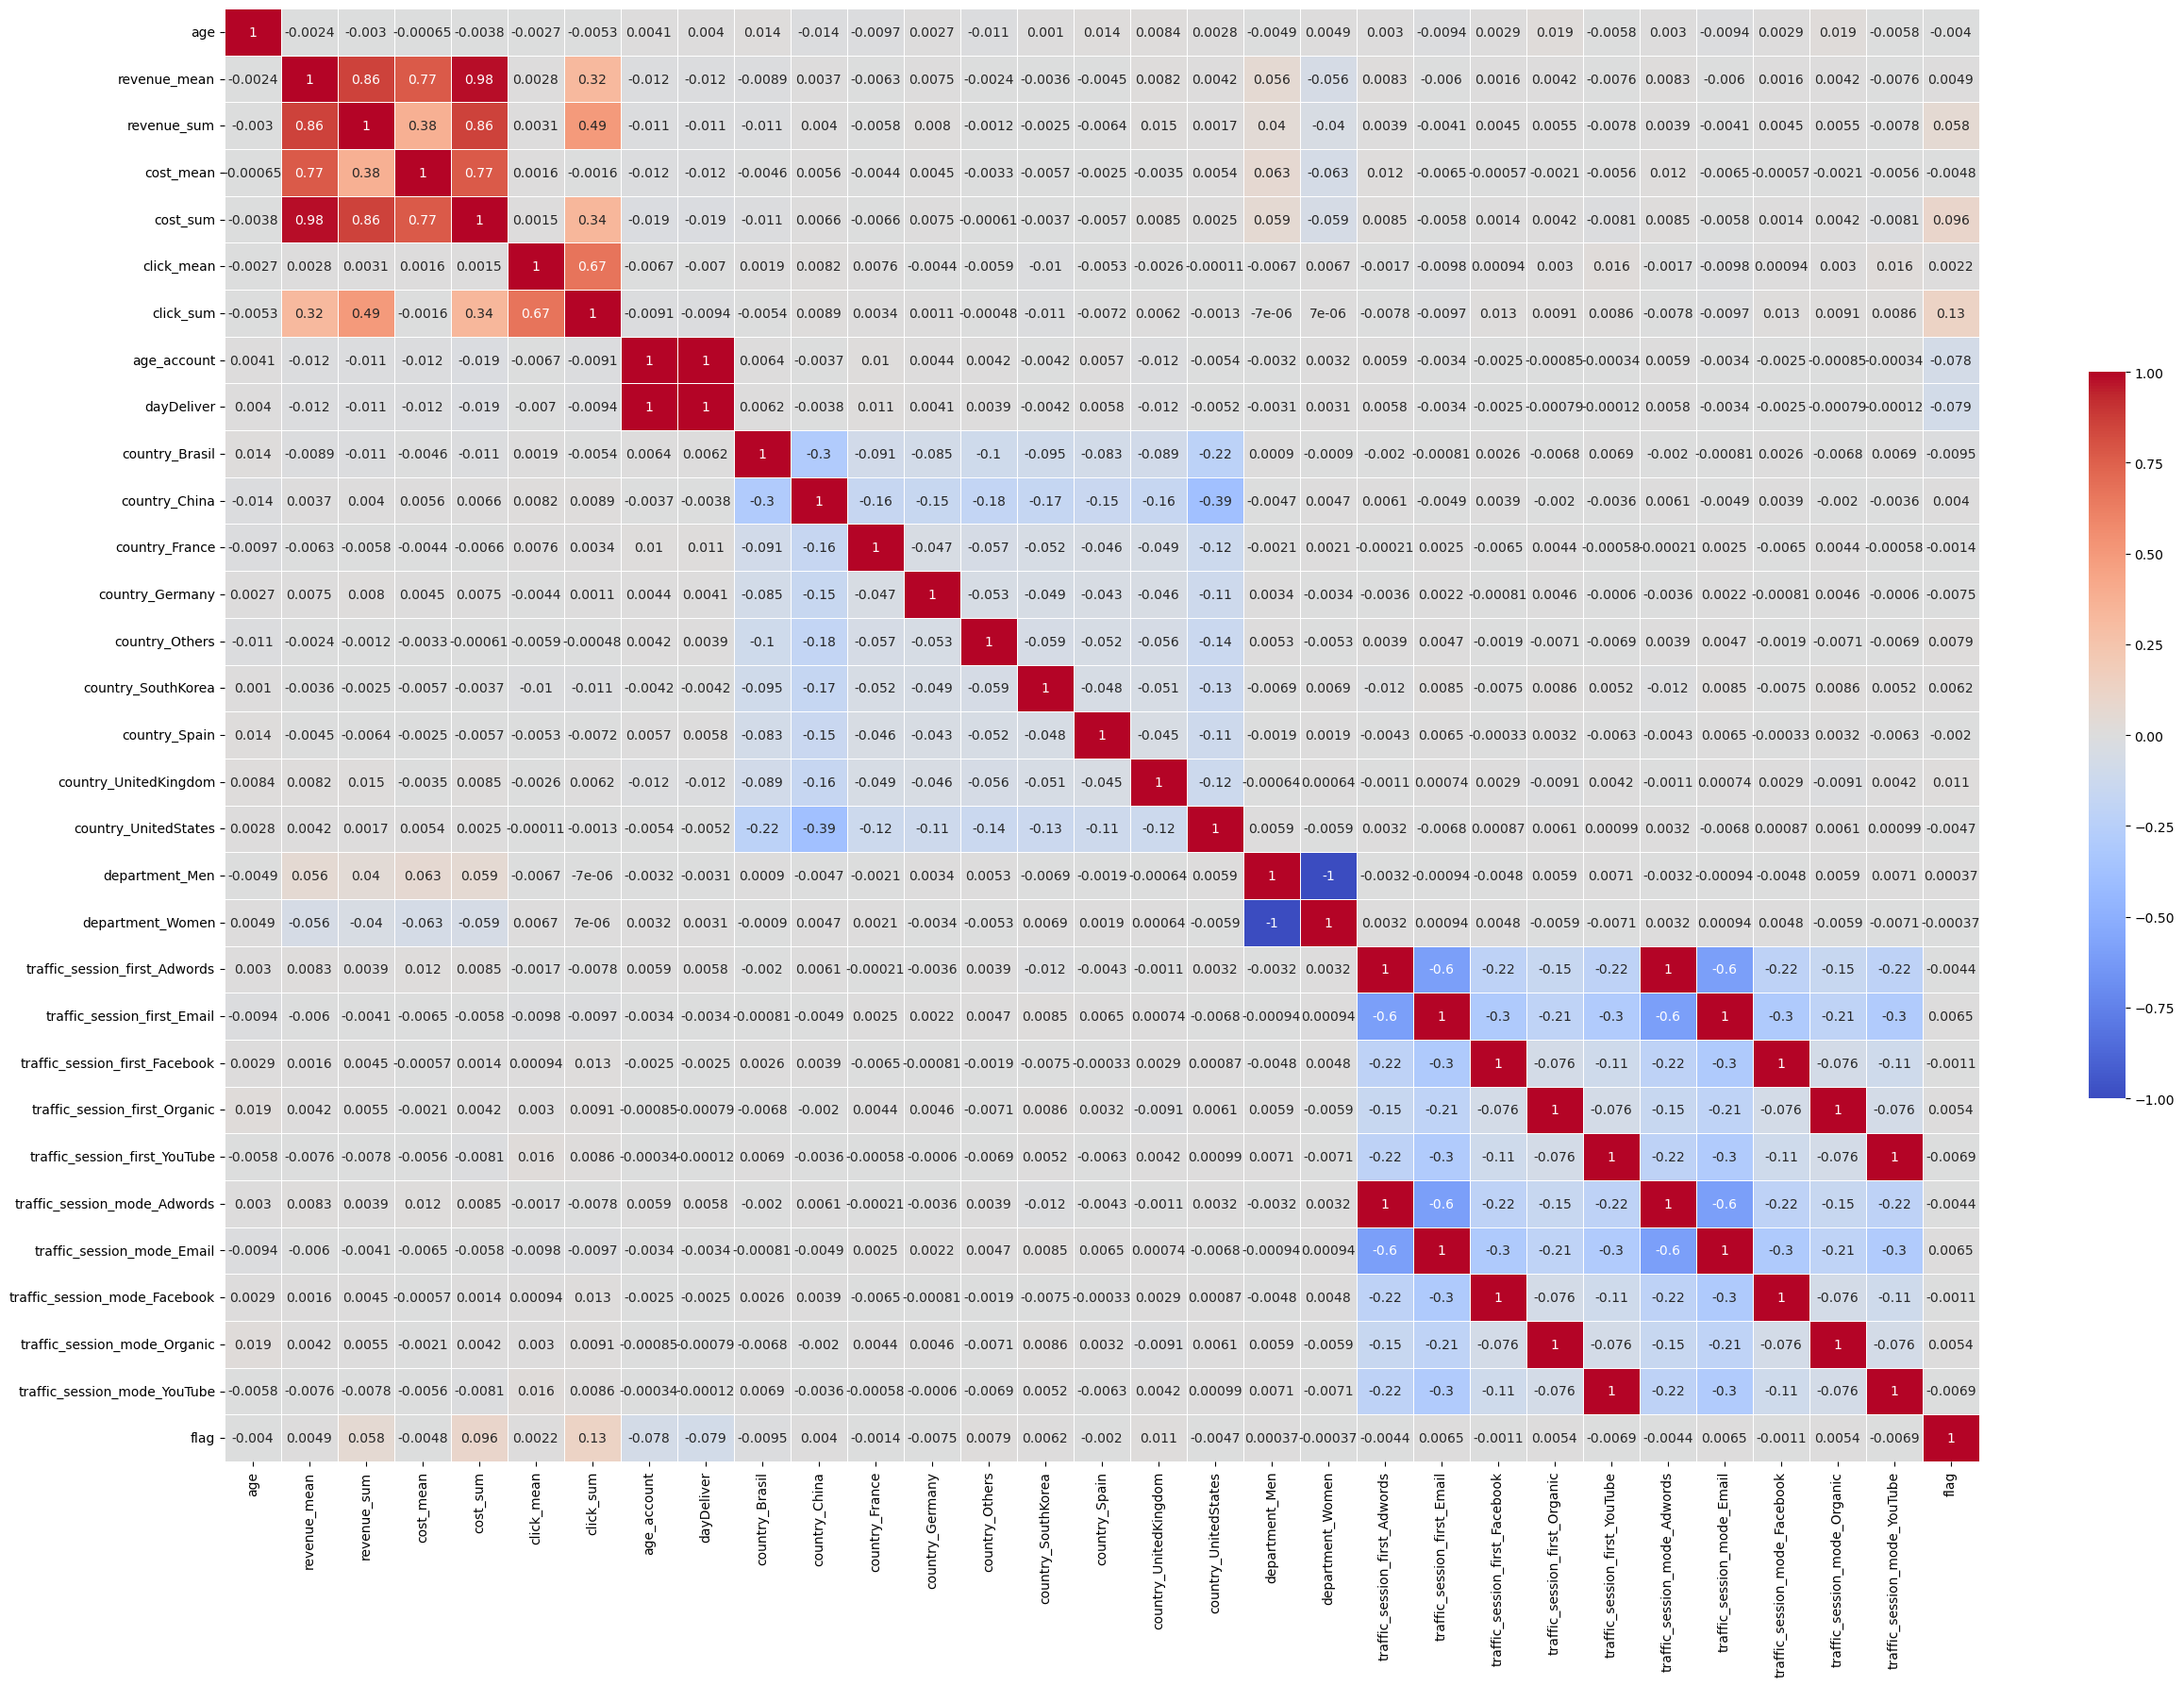

In [39]:
corr = df_grouped.select_dtypes(include=['number']).corr()

plt.figure(figsize=(30, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [40]:
from sklearn.model_selection import train_test_split

target = 'flag'

X = df_grouped.drop(target, axis=1)
y = df_grouped[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train shape: {X_train.shape}\n Test shape: {X_test.shape}")
print("Target label distribution: ", y_train.value_counts(normalize=True))
print("Test label distribution: ", y_test.value_counts(normalize=True))

Train shape: (24738, 30)
 Test shape: (6185, 30)
Target label distribution:  flag
0    0.988439
1    0.011561
Name: proportion, dtype: float64
Test label distribution:  flag
0    0.988521
1    0.011479
Name: proportion, dtype: float64


In [ ]:
!pip uninstall imblearn

In [ ]:
!pip install -U imbalanced-learn

In [41]:
from sklearn.linear_model import LogisticRegression
# from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy=0.5)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print("Train label distribution: ", y_train.value_counts(normalize=True))

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (C:\Users\Baha Tegar\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py)

In [ ]:
# df_grouped = df.copy()

# df_grouped['delayDay'] = (df_grouped['delivered_date'] - df_grouped['order_date']) / pd.to_timedelta(1, 'day')
# df_grouped = df_grouped.groupby()
# df_grouped.head()

In [ ]:
# df_grouped = df.copy()
# df_grouped['year_month'] = df_grouped['order_date'].dt.to_period('M')

# more_than_one = (df_grouped.groupby(['user_id', 'year_month'])
#                  .filter(lambda x: x['order_id'].nunique() > 1))
# more_than_one['flag'] = np.ones(more_than_one.shape[0], dtype=int)

# less_than_one = (df_grouped.groupby(['user_id', 'year_month'])
#                  .filter(lambda x: x['order_id'].nunique() == 1))
# less_than_one['flag'] = np.zeros(less_than_one.shape[0], dtype=int)

# df_example = pd.concat([more_than_one, less_than_one], axis=0)
# df_example = df_example\
#                 .groupby(['user_id', 'year_month'])\
#                 .agg({'session_id': 'nunique', 'flag': 'first'})\
#                 .reset_index()

# print(df_example.info())
# print(df_example[df_example['flag'] == 1].shape)
# print(df_example[df_example['flag'] == 0].shape)
# df_example.head()

In [ ]:
# import pandas as pd

# # Sample data
# data = {
#     'user_id': [1, 1, 1, 2, 2, 3, 3, 3, 3],
#     'order_date': ['2024-01-01', '2024-01-15', '2024-02-20', '2024-01-05', '2024-02-25', '2024-01-10', '2024-01-20', '2024-02-15', '2024-02-18'],
#     'order_id': [101, 102, 103, 104, 105, 106, 107, 108, 109]
# }

# # Create DataFrame
# df = pd.DataFrame(data)

# # Convert order_date to datetime
# df['order_date'] = pd.to_datetime(df['order_date'])

# # Extract month and year from order_date
# df['year_month'] = df['order_date'].dt.to_period('M')

# # Group by user_id and year_month and filter for those with more than one order_id
# more_than_one = (df.groupby(['user_id', 'year_month'])
#                  .filter(lambda x: x['order_id'].nunique() > 1))
# more_than_one['flag'] = np.ones(more_than_one.shape[0], dtype=int)

# less_than_one = (df.groupby(['user_id', 'year_month'])
#                  .filter(lambda x: x['order_id'].nunique() == 1))
# less_than_one['flag'] = np.zeros(less_than_one.shape[0], dtype=int)

# print(df)
# pd.concat([more_than_one, less_than_one], axis=0)

In [ ]:
df_wrangled = df.copy()

# Create helper function
def categorized_country(x):
    if x in ['China', 'United States', 'Brasil', 'South Korea', 'France', 'United Kingdom', 'Spain', 'Germany']:
        return x
    else:
        return 'Others'
    
df_wrangled['country'] = df_wrangled['country'].apply(categorized_country)

# Create new field 'age account'
currentDate = df_wrangled['order_date'].max()
df_wrangled['age_account'] = (df_wrangled['order_date'] - df_wrangled['created_account_date']) / pd.to_timedelta(1, 'day')

# Bin the 'age account'
def binned(x):
    if x <= 30:
        return 'less_1month'
    elif x <= 120:
        return 'less_3month'
    elif x <= 180:
        return 'less_6month'
    elif x <= 360:
        return 'less_12month'
    else:
        return 'more_12month'

df_wrangled['age_account'] = df_wrangled['age_account'].apply(binned)

# Encoding
enc_columns = ['country', 'department', 'traffic_session', 'age_account']

for c in enc_columns:
    temp = pd.get_dummies(df_wrangled[c]).astype(int)
    temp.columns = [c + '_' + i.replace(" ", "") for i in temp.columns]
    df_wrangled = pd.concat([df_wrangled, temp], axis=1)

df_wrangled = df_wrangled.drop(['country', 'department', 'traffic_session', 'age_account', 'created_account_date'], axis=1)

print(df_wrangled.info())
df_wrangled.head()

In [ ]:
map_aggregate = {
    'cost': 'sum',
    'session_id': 'nunique',
    'revenue': 'sum',
    'country_Brasil': 'sum',
    'country_China': 'sum',
    'country_France': 'sum',
    'country_Germany': 'sum',
    'country_Others': 'sum',
    'country_SouthKorea': 'sum',
    'country_Spain': 'sum',
    'country_UnitedKingdom': 'sum',
    'country_UnitedStates': 'sum',
    'department_Men': 'sum',
    'department_Women': 'sum',
    'traffic_session_Adwords': 'sum',
    'traffic_session_Email': 'sum',
    'traffic_session_Facebook': 'sum',
    'traffic_session_Organic': 'sum',
    'traffic_session_YouTube': 'sum',
    'age_account_less_1month': 'sum',
    'age_account_less_3month': 'sum',
    'age_account_less_6month': 'sum',
    'age_account_less_12month': 'sum',
    'age_account_more_12month': 'sum',
}

df_wrangled = df_wrangled.groupby(['order_date']).agg(map_aggregate)

print(df_wrangled.info())
df_wrangled.head()

In [ ]:
df_wrangled.corr()

In [ ]:
df_wrangled.corr()['revenue']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.metrics import mean_squared_error, r2_score


category_dict = {'department': ['department_Men', 'department_Women'],
                 'event_traffic_source': ['traffic_session_Adwords', 'traffic_session_Email', 'traffic_session_Facebook',
                                          'traffic_session_Organic', 'traffic_session_YouTube'],
                 'age_account_category': ['age_account_less_1month', 'age_account_less_3month', 
                                          'age_account_less_6month', 'age_account_less_12month', 
                                          'age_account_more_12month']
                }


y = df_wrangled['revenue']
result = pd.DataFrame()
for c in category_dict.keys():
    X = df_wrangled[category_dict[c]]
    model = LinearRegression()
    model.fit(X, y)
    temp = pd.DataFrame(model.coef_, index=X.columns, columns=[c]).T
    result = pd.concat([temp, result])
    
    print(f"RMSE {c}", mean_squared_error(model.predict(X), y)**0.5)
    print(f"R2 Score {c}", r2_score(model.predict(X), y))

result

In [ ]:
# result.to_csv('./coefficient-result.csv')